# Assignment - Feature Engineering 2

In this assignment, you'll continue working with the U.S. Education Dataset from Kaggle. 


Don't forget to apply the most suitable missing value filling techniques you applied in the previous checkpoints to the data. 

You should provide your answers to the following questions after you handled the missing values.

Say, we want to understand the relationship between the expenditures of the governments and the students' overall success in the math and reading.

* Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.
* What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?
* Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?
* What is the correlation between the overall score variable and the 1st principal component?
* If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?


In [2]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats.mstats import winsorize

from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox


warnings.filterwarnings('ignore')

In [3]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

In [5]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from useducation',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492 entries, 0 to 1491
Data columns (total 25 columns):
PRIMARY_KEY                     1492 non-null object
STATE                           1492 non-null object
YEAR                            1492 non-null int64
ENROLL                          1229 non-null float64
TOTAL_REVENUE                   1280 non-null float64
FEDERAL_REVENUE                 1280 non-null float64
STATE_REVENUE                   1280 non-null float64
LOCAL_REVENUE                   1280 non-null float64
TOTAL_EXPENDITURE               1280 non-null float64
INSTRUCTION_EXPENDITURE         1280 non-null float64
SUPPORT_SERVICES_EXPENDITURE    1280 non-null float64
OTHER_EXPENDITURE               1229 non-null float64
CAPITAL_OUTLAY_EXPENDITURE      1280 non-null float64
GRADES_PK_G                     1319 non-null float64
GRADES_KG_G                     1360 non-null float64
GRADES_4_G                      1361 non-null float64
GRADES_8_G                      1

In [7]:
# check for missing values
df.isnull().sum()*100/df.isnull().count()

PRIMARY_KEY                      0.000000
STATE                            0.000000
YEAR                             0.000000
ENROLL                          17.627346
TOTAL_REVENUE                   14.209115
FEDERAL_REVENUE                 14.209115
STATE_REVENUE                   14.209115
LOCAL_REVENUE                   14.209115
TOTAL_EXPENDITURE               14.209115
INSTRUCTION_EXPENDITURE         14.209115
SUPPORT_SERVICES_EXPENDITURE    14.209115
OTHER_EXPENDITURE               17.627346
CAPITAL_OUTLAY_EXPENDITURE      14.209115
GRADES_PK_G                     11.595174
GRADES_KG_G                      8.847185
GRADES_4_G                       8.780161
GRADES_8_G                       8.780161
GRADES_12_G                      8.780161
GRADES_1_8_G                     8.780161
GRADES_9_12_G                    8.780161
GRADES_ALL_G                    11.595174
AVG_MATH_4_SCORE                64.075067
AVG_MATH_8_SCORE                64.343164
AVG_READING_4_SCORE             64

In [9]:
education_df = df.copy()
# drop some of the values 50% or more missing data and fill the missing values for others
# use interpolation to fill in the rest of the values
fill_list = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G"]

states = education_df["STATE"].unique()

for state in states:
    education_df.loc[education_df["STATE"] == state, fill_list] = education_df.loc[education_df["STATE"] == state, fill_list].interpolate()

# we drop the null values after interpolation
education_df.dropna(inplace=True)

### Creating variable
* Create a new score variable from the weighted averages of all score variables in the datasets. Notice that the number of students in the 4th grade isn't the same as the number of students in the 8th grade. So, you should appropriately weigh the scores!.

In [10]:
# weighted the score variables using the number of students in the respective grades.
education_df["overall_score"] = (education_df["GRADES_4_G"]*((education_df["AVG_MATH_4_SCORE"] + education_df["AVG_READING_4_SCORE"])*0.5) + education_df["GRADES_8_G"]
                                 * ((education_df["AVG_MATH_8_SCORE"] + education_df["AVG_READING_8_SCORE"])*0.5))/(education_df["GRADES_4_G"] + education_df["GRADES_8_G"])

### Correlation
* What are the correlations between this newly created score variable and the expenditure types? Which 1 of the expenditure types is more correlated than the others?

In [11]:
education_df[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr()

,overall_score,TOTAL_EXPENDITURE,INSTRUCTION_EXPENDITURE,SUPPORT_SERVICES_EXPENDITURE,OTHER_EXPENDITURE,CAPITAL_OUTLAY_EXPENDITURE
overall_score,1.000000,0.074155,0.087386,0.079002,0.010959,-0.005389
TOTAL_EXPENDITURE,0.074155,1.000000,0.990255,0.992988,0.943702,0.925784
INSTRUCTION_EXPENDITURE,0.087386,0.990255,1.000000,0.974399,0.902173,0.884798
SUPPORT_SERVICES_EXPENDITURE,0.079002,0.992988,0.974399,1.000000,0.952282,0.911245
OTHER_EXPENDITURE,0.010959,0.943702,0.902173,0.952282,1.000000,0.918188
CAPITAL_OUTLAY_EXPENDITURE,-0.005389,0.925784,0.884798,0.911245,0.918188,1.000000


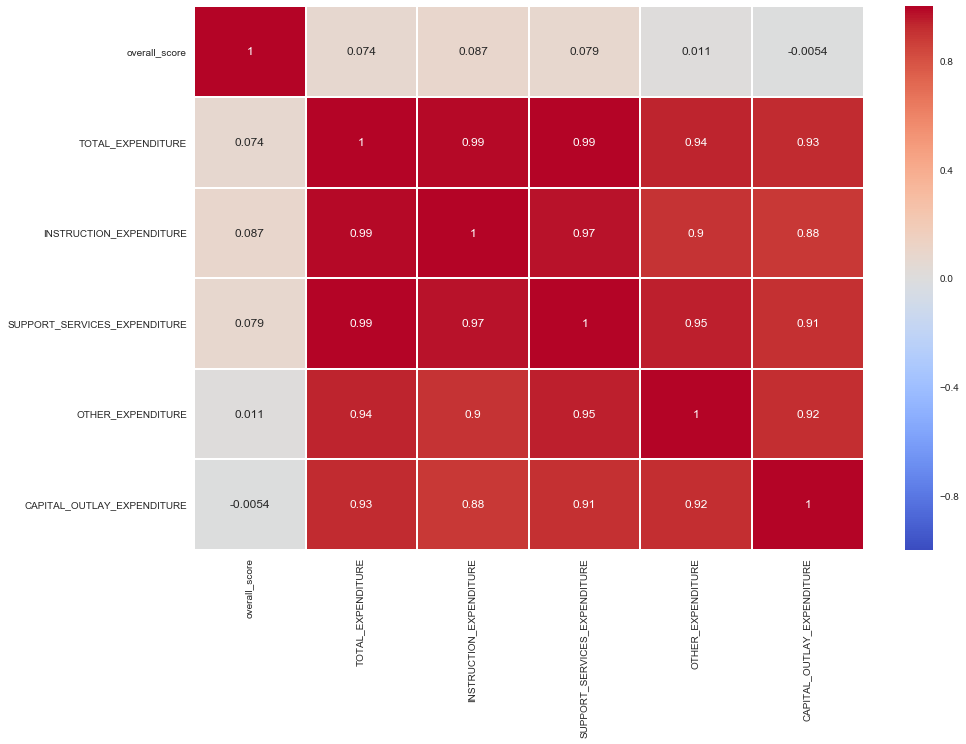

In [12]:
plt.figure(figsize=(30,20))
plt.subplots(figsize=(15, 10))

sns.heatmap(education_df[["overall_score", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr(), linewidths=1, annot=True, cmap = 'coolwarm')
plt.show()

### PCA
* Now, apply PCA to the 4 expenditure types. How much of the total variance is explained by the 1st component?

In [13]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = education_df[["INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
                  "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]]

#
X = StandardScaler().fit_transform(X)

sklearn_pca = PCA(n_components=1) # is this just 1 component?
education_df["pca_1"] = sklearn_pca.fit_transform(X)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.9430175]


More than 94% of the total variance is explained by the first principal component.

### Analyze
* What is the correlation between the overall score variable and the 1st principal component?


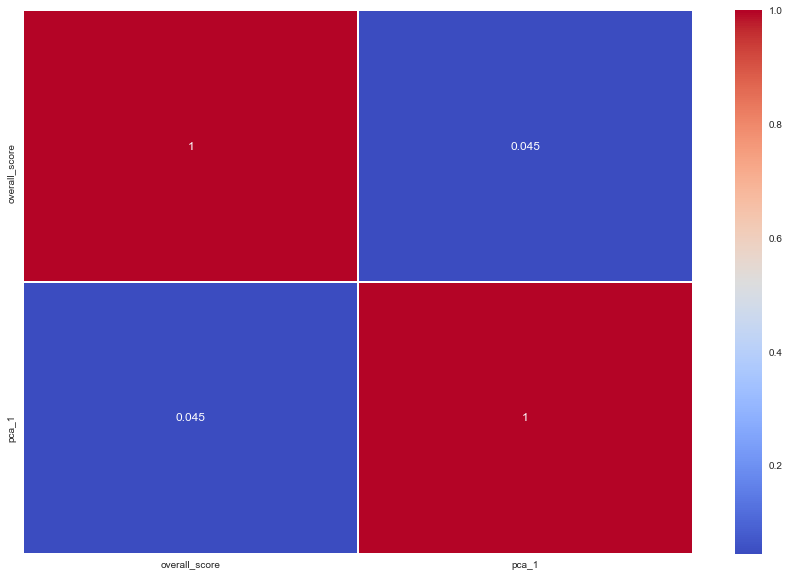

In [19]:
plt.figure(figsize=(30,20))
plt.subplots(figsize=(15, 10))

#sns.heatmap(education_df[["overall_score", "pca_1", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
#              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr(), linewidths=1, annot=True, cmap = 'coolwarm')
sns.heatmap(education_df[["overall_score", "pca_1"]].corr(), linewidths=1, annot=True, cmap = 'coolwarm')

plt.show()

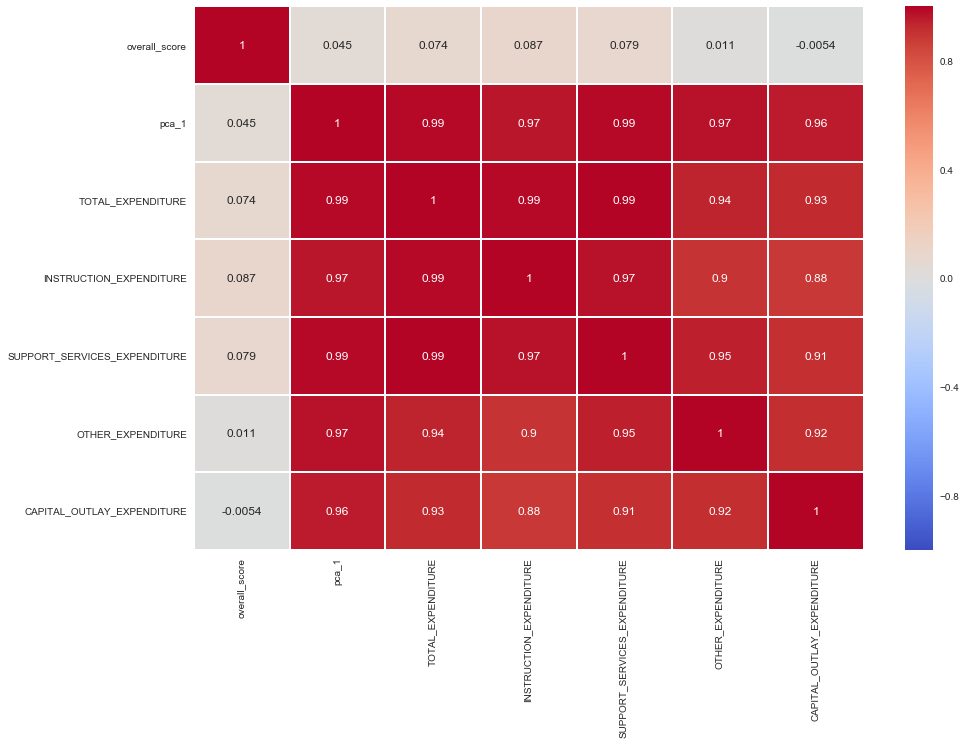

In [20]:
plt.figure(figsize=(30,20))
plt.subplots(figsize=(15, 10))

sns.heatmap(education_df[["overall_score", "pca_1", "TOTAL_EXPENDITURE", "INSTRUCTION_EXPENDITURE",
              "SUPPORT_SERVICES_EXPENDITURE", "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE"]].corr(), linewidths=1, annot=True, cmap = 'coolwarm')
#sns.heatmap(education_df[["overall_score", "pca_1"]].corr(), linewidths=1, annot=True, cmap = 'coolwarm')

plt.show()

### Analyze
- * If you were to choose the best variables for your model, would you prefer using the 1st principal component instead of the expenditure variables? Why?

## Magda Question
- what does the fit_transform(X) do?
- From PCA If it is one - the number has to be High - because its telling that that one feature gives you the most information -
- Not understanding what PCA is doing here and how is the one feature corellated or not